In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score
)


In [30]:
df = pd.read_csv('Dataset_Abandon_Scolaire.csv')

In [31]:
print("Aperçu des données :")
print(df.head())
print("\nTypes de données :")
print(df.dtypes)

Aperçu des données :
   Age   Sexe  Taux_presence  Nombre_retards  Note_moyenne  \
0   21  Femme      89.585023               2     15.826896   
1   20  Homme      70.713068               3     12.829358   
2   22  Femme      82.122963               1     13.086319   
3   24  Homme      87.408859               3     14.992032   
4   20  Homme      86.470676               3     12.671649   

  Situation_familiale  Abandon  
0    Enfants à charge        0  
1         Célibataire        0  
2    Enfants à charge        0  
3         Célibataire        0  
4               Marié        0  

Types de données :
Age                      int64
Sexe                    object
Taux_presence          float64
Nombre_retards           int64
Note_moyenne           float64
Situation_familiale     object
Abandon                  int64
dtype: object


Nous avons affiché les données du jeu ainsi que le type de chaque variable. On remarque que deux colonnes, "situation familiale" et "sexe", sont de type object, ce qui indique qu’elles contiennent des valeurs catégorielles (texte ou labels). Les autres variables sont de types numériques, plus précisément des int (entiers) ou des float (nombres décimaux).

Ce point est important car les modèles de machine learning, comme Random Forest ou la régression logistique, ne peuvent pas directement traiter les variables de type object. Il est donc nécessaire de transformer ces variables catégorielles en valeurs numériques, par exemple en utilisant un encodage (comme LabelEncoder ou OneHotEncoder), avant d'entraîner un modèle.

In [32]:
print("\nValeurs manquantes :")
print(df.isnull().sum())


Valeurs manquantes :
Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64


On peut voir qu'il n'y a aucune valeur manquante dans le dataset. Cela nous évite de devoir nettoyer ou compléter les données, ce qui simplifie le prétraitement. De plus, l'absence de valeurs manquantes réduit le risque de biais ou d’erreurs dans les résultats du modèle.


Statistiques descriptives :
              Age   Sexe  Taux_presence  Nombre_retards  Note_moyenne  \
count   2000.0000   2000    2000.000000     2000.000000   2000.000000   
unique        NaN      2            NaN             NaN           NaN   
top           NaN  Homme            NaN             NaN           NaN   
freq          NaN   1011            NaN             NaN           NaN   
mean      20.5930    NaN      84.637016        2.593500     13.441019   
std        2.0133    NaN       7.921973        1.788255      1.809283   
min       14.0000    NaN      59.586369        0.000000      7.615012   
25%       19.0000    NaN      79.279829        1.000000     12.268147   
50%       21.0000    NaN      84.813868        3.000000     13.470242   
75%       22.0000    NaN      90.169016        4.000000     14.688037   
max       28.0000    NaN     100.000000        9.000000     18.833574   

       Situation_familiale      Abandon  
count                 2000  2000.000000  
unique    

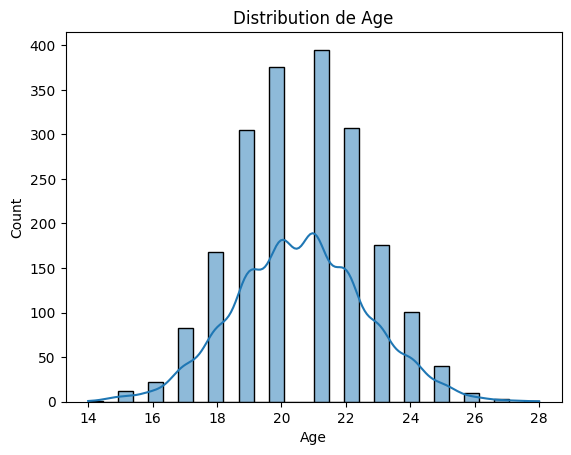

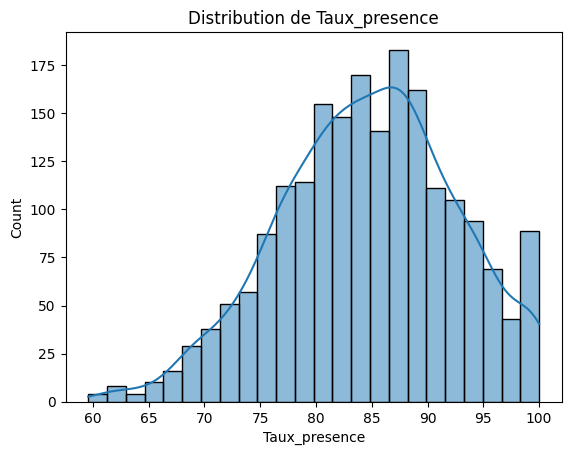

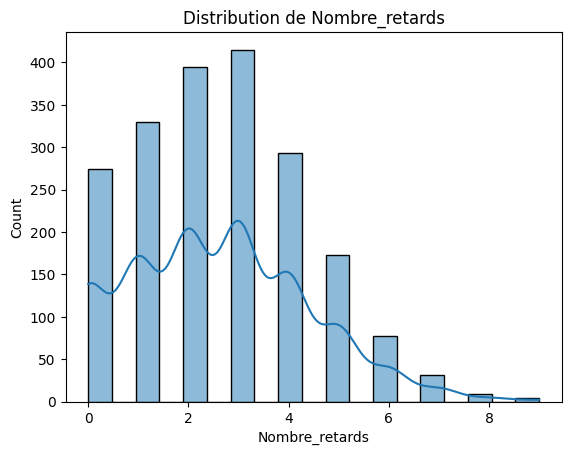

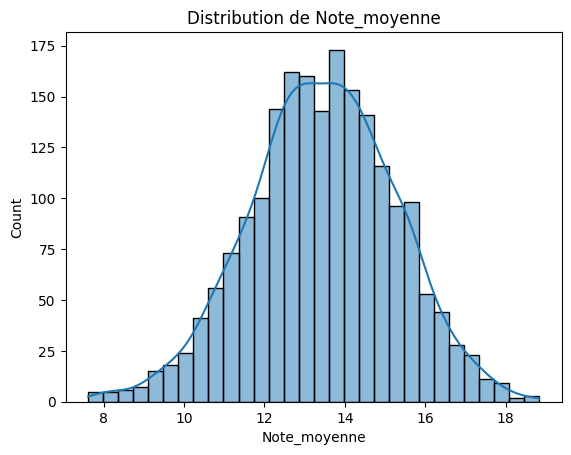

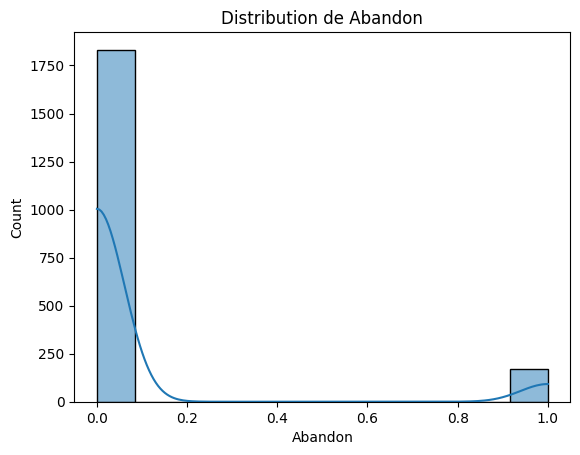

In [33]:
print("\nStatistiques descriptives :")
print(df.describe(include='all'))

numeriques = df.select_dtypes(include=[np.number])
for col in numeriques.columns:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

Âge :
La moyenne d'âge est de 20,6 ans avec un écart-type faible (≈ 2 ans), ce qui indique que la population est relativement homogène.
L’âge minimum est de 14 ans et le maximum de 28 ans. Ces valeurs, bien que légèrement extrêmes, restent cohérentes avec le contexte et ne faussent pas la distribution, qui semble proche d'une loi normale.

Taux de présence :
La moyenne est élevée, à 84,6 %, avec un minimum de 59,6 % et un maximum de 100 %. Cela montre une bonne assiduité générale des étudiants, bien que certains présentent des taux assez bas.

Nombre de retards :
La moyenne est de 2,59 retards, avec un maximum de 9 retards. La médiane est de 3, ce qui signifie que la majorité des étudiants ont au moins quelques retards. Il faudra être vigilant sur cette variable lors de la modélisation, car elle peut être significative dans la prédiction de l’abandon.

Note moyenne :
La moyenne des notes est de 13,4 / 20, avec une valeur minimale de 7,6 et un maximum de 18,8. La distribution semble relativement équilibrée autour de la moyenne.

Taux d’abandon :
8,4 % des étudiants ont abandonné (soit 168 sur 2000). Ce faible taux montre un déséquilibre de classes à prendre en compte lors de la modélisation (via des techniques comme la stratification, le rééchantillonnage ou l’usage de pondérations).


 Variables qualitatives
Sexe :
Deux modalités sont présentes : Homme et Femme. La valeur la plus fréquente est Homme (1 011 sur 2 000), indiquant une répartition relativement équilibrée entre les genres.

Situation familiale :
Quatre modalités sont présentes. La plus représentée est "Célibataire" avec 1 014 individus.
Les autres catégories probables incluent : Marié(e), Divorcé(e) et Enfant à charge.

<Axes: xlabel='Age', ylabel='Count'>

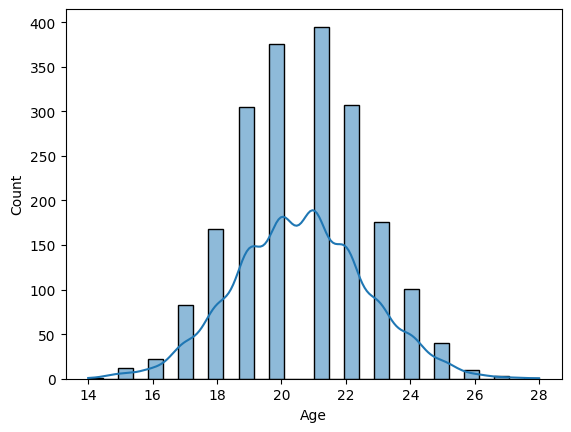

In [34]:
sns.histplot(df['Age'], kde=True)

L’histogramme montre que la distribution de l’âge des étudiants suit une forme symétrique et légèrement en cloche, ce qui suggère une distribution proche d’une loi normale.

La majorité des âges sont concentrés entre 18 et 23 ans, avec un pic autour de 21 ans, ce qui correspond à la moyenne observée (≈ 20,6 ans).

Les valeurs extrêmes, comme 14 ou 28 ans, sont très peu représentées et ne constituent pas des outliers problématiques.

La courbe KDE (Kernel Density Estimate) superposée renforce cette idée de normalité, ce qui est souvent un avantage pour certaines méthodes statistiques.

Cette distribution homogène facilite l’interprétation et l’exploitation de la variable âge dans les modèles prédictifs.

In [35]:
df.isnull().sum()

Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64

 L’analyse des valeurs manquantes montre que le dataset ne contient aucune valeur NaN. Toutes les variables sont complètes et ne nécessitent pas de traitement particulier pour les données manquantes.

In [36]:
df.duplicated().sum()

np.int64(0)

L’analyse des doublons indique qu’aucune ligne du dataset n’est dupliquée. Cela signifie que chaque observation est unique, ce qui garantit la qualité et la représentativité des données. Aucune suppression de doublons n’est nécessaire

<Axes: ylabel='Age'>

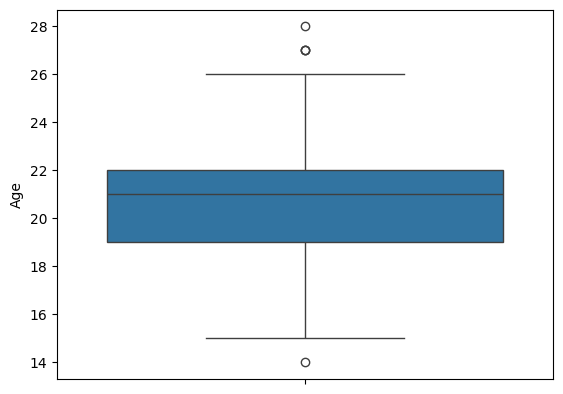

In [37]:
sns.boxplot(data=df['Age'])

L’histogramme met en évidence que la majorité des individus ont un âge compris entre 20 et 22 ans, ce qui correspond à la moyenne observée. Cette concentration justifie le choix de se focaliser sur cette tranche d’âge pour approfondir l’analyse.

<Axes: xlabel='Taux_presence', ylabel='Count'>

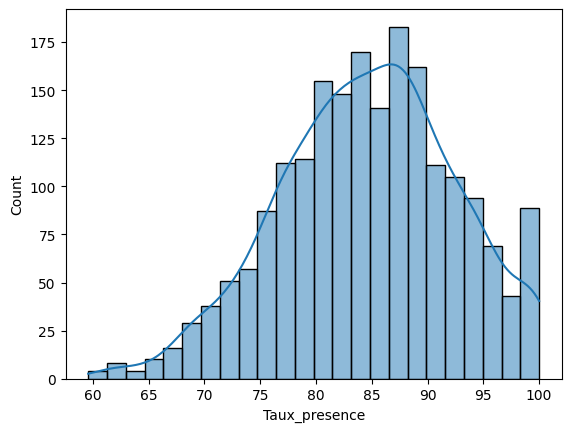

In [38]:
sns.histplot(df['Taux_presence'], kde=True)

La distribution du taux de présence présente une légère asymétrie négative (queue à gauche), avec un pic autour de 85 %. Cela indique que la majorité des élèves ont un taux de présence élevé, généralement compris entre 80 % et 90 %. Très peu d’élèves ont un taux inférieur à 70 %, mais ces cas pourraient correspondre à des profils à risque d’abandon, à surveiller de près.

In [39]:
df['Abandon'].value_counts(normalize=True)

Abandon
0    0.916
1    0.084
Name: proportion, dtype: float64

La variable cible "Abandon" montre que 91,6 % des élèves n’ont pas abandonné, tandis que 8,4 % ont abandonné. Cela indique un fort déséquilibre des classes, avec une minorité d’élèves en situation d’abandon. Ce déséquilibre devra être pris en compte lors de la modélisation, en appliquant par exemple des techniques d’échantillonnage (comme le sur-échantillonnage via SMOTE, le sous-échantillonnage de la classe majoritaire, ou encore la pondération des classes) ainsi que des métriques adaptées telles que le F1-score ou l’AUC.

In [40]:
df.corr(numeric_only=True)

,Age,Taux_presence,Nombre_retards,Note_moyenne,Abandon
Age,1.000000,0.008802,-0.004709,0.032478,-0.029216
Taux_presence,0.008802,1.000000,-0.827747,0.809474,-0.473189
Nombre_retards,-0.004709,-0.827747,1.000000,-0.726548,0.444926
Note_moyenne,0.032478,0.809474,-0.726548,1.000000,-0.426708
Abandon,-0.029216,-0.473189,0.444926,-0.426708,1.000000


In [41]:
df['Sexe'] = df['Sexe'].astype('category')
df['Situation_familiale'] = df['Situation_familiale'].astype('category')
df_clean = df

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  2000 non-null   int64   
 1   Sexe                 2000 non-null   category
 2   Taux_presence        2000 non-null   float64 
 3   Nombre_retards       2000 non-null   int64   
 4   Note_moyenne         2000 non-null   float64 
 5   Situation_familiale  2000 non-null   category
 6   Abandon              2000 non-null   int64   
dtypes: category(2), float64(2), int64(3)
memory usage: 82.5 KB


on a changer le type de object en category pour eviter une perte de perf au niveau de la ram

In [43]:
corr_matrix = df.corr(numeric_only=True)

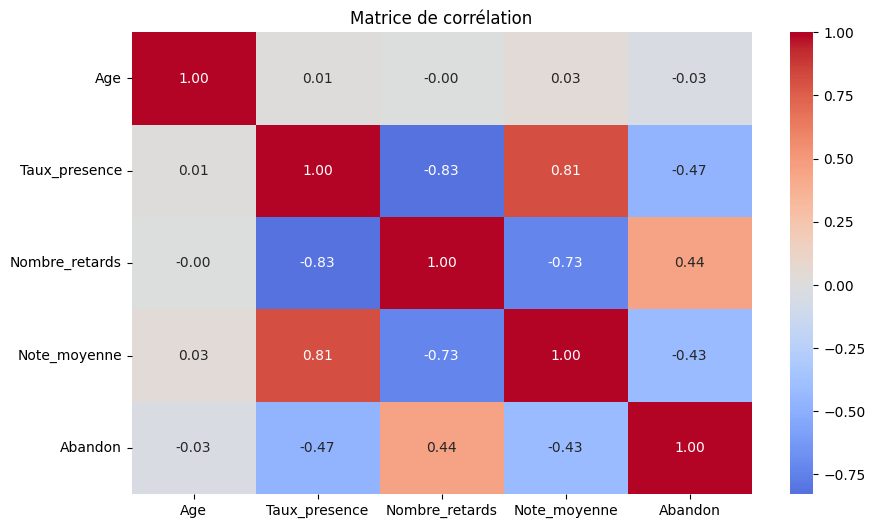

In [44]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

Taux de presence est de -0.47 _Corrélation négative modérée → les élèves moins présents sont plus susceptibles d’abandonner
Nombre de retards +0.44 Corrélation positive modérée → plus de retards = plus de risque d’abandon
Note de moyenne  -0.43 Corrélation négative modérée → notes faibles associées à l’abandon
Age -0.03 Corrélation quasi nulle → l’âge n’a pas d’impact significatif sur l’abandon

Variables	Corrélation	Interprétation
Taux_presence et Note_moyenne +0.81 Les élèves plus présents ont de meilleures notes.
Taux_presence et Retards -0.82 Plus un élève a de retards, moins son taux de présence est élevé.
Retards et Note_moyenne -0.73 Plus d’absences sont associées à des notes plus faibles.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
df_encoded = pd.get_dummies(df_clean, columns=['Sexe','Situation_familiale'], drop_first=True)

Afin de n'utiliser que des valeurs numériques, nous transformons les colonnes "sexe" et "situation_familiale", de type catégoriel, en variables booléennes à l'aide de la fonction get_dummies. Cela permet d'obtenir un dataset entièrement numérique.

In [46]:
print(df_encoded)

      Age  Taux_presence  Nombre_retards  Note_moyenne  Abandon  Sexe_Homme  \
0      21      89.585023               2     15.826896        0       False   
1      20      70.713068               3     12.829358        0        True   
2      22      82.122963               1     13.086319        0       False   
3      24      87.408859               3     14.992032        0        True   
4      20      86.470676               3     12.671649        0        True   
...   ...            ...             ...           ...      ...         ...   
1995   23      81.800974               3     12.496245        0       False   
1996   20      84.082873               4     13.125663        0        True   
1997   19      87.114146               1     13.841282        0       False   
1998   20      83.799064               3     12.061256        0       False   
1999   19      74.887951               6      9.467544        1        True   

      Situation_familiale_Divorcé  Situation_famili

In [47]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age                                   2000 non-null   int64  
 1   Taux_presence                         2000 non-null   float64
 2   Nombre_retards                        2000 non-null   int64  
 3   Note_moyenne                          2000 non-null   float64
 4   Abandon                               2000 non-null   int64  
 5   Sexe_Homme                            2000 non-null   bool   
 6   Situation_familiale_Divorcé           2000 non-null   bool   
 7   Situation_familiale_Enfants à charge  2000 non-null   bool   
 8   Situation_familiale_Marié             2000 non-null   bool   
dtypes: bool(4), float64(2), int64(3)
memory usage: 86.1 KB


-----------------------------------------------------------------------------------------------

Nous allons appliquer le clustering k-means sur notre jeu de données et utiliser l'analyse en composantes principales (PCA) pour déterminer le nombre optimal de clusters. Pour cela, nous commencerons également par standardiser nos données.

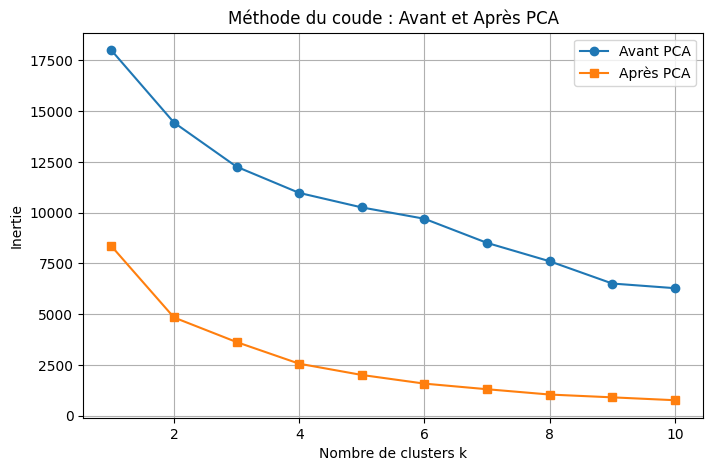

In [48]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

inertia_before = []
inertia_after = []

K_range = range(1, 11)

for k in K_range:
    kmeans_before = KMeans(n_clusters=k, random_state=42)
    kmeans_before.fit(X_scaled)
    inertia_before.append(kmeans_before.inertia_)
    
    kmeans_after = KMeans(n_clusters=k, random_state=42)
    kmeans_after.fit(X_pca)
    inertia_after.append(kmeans_after.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_before, marker='o', label='Avant PCA')
plt.plot(K_range, inertia_after, marker='s', label='Après PCA')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Inertie')
plt.title('Méthode du coude : Avant et Après PCA')
plt.legend()
plt.grid(True)
plt.show()



On peut observer que le PCA réduit la quantité d'information car son objectif est de conserver uniquement les composantes principales expliquant le plus de variance dans les données. En projetant les données dans un espace de plus faible dimension, on élimine le bruit et les redondances, ce qui peut entraîner une légère perte d'inertie mais améliore la clarté des structures sous-jacentes pour le clustering.

In [49]:
best_score = -1
best_k = None

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"Score silhouette pour k={k} : {score:.3f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nMeilleur score silhouette : {best_score:.3f} pour k = {best_k}")


Score silhouette pour k=2 : 0.380
Score silhouette pour k=3 : 0.374
Score silhouette pour k=4 : 0.402
Score silhouette pour k=5 : 0.435

Meilleur score silhouette : 0.435 pour k = 5


L’approche utilisée ici consiste à appliquer la méthode du coude pour visualiser le nombre optimal de clusters potentiels, puis à utiliser le score de silhouette pour affiner ce choix et déterminer le nombre de clusters offrant la meilleure cohésion, ici k = 5.

-----------------------------------------------------------------------------------------------

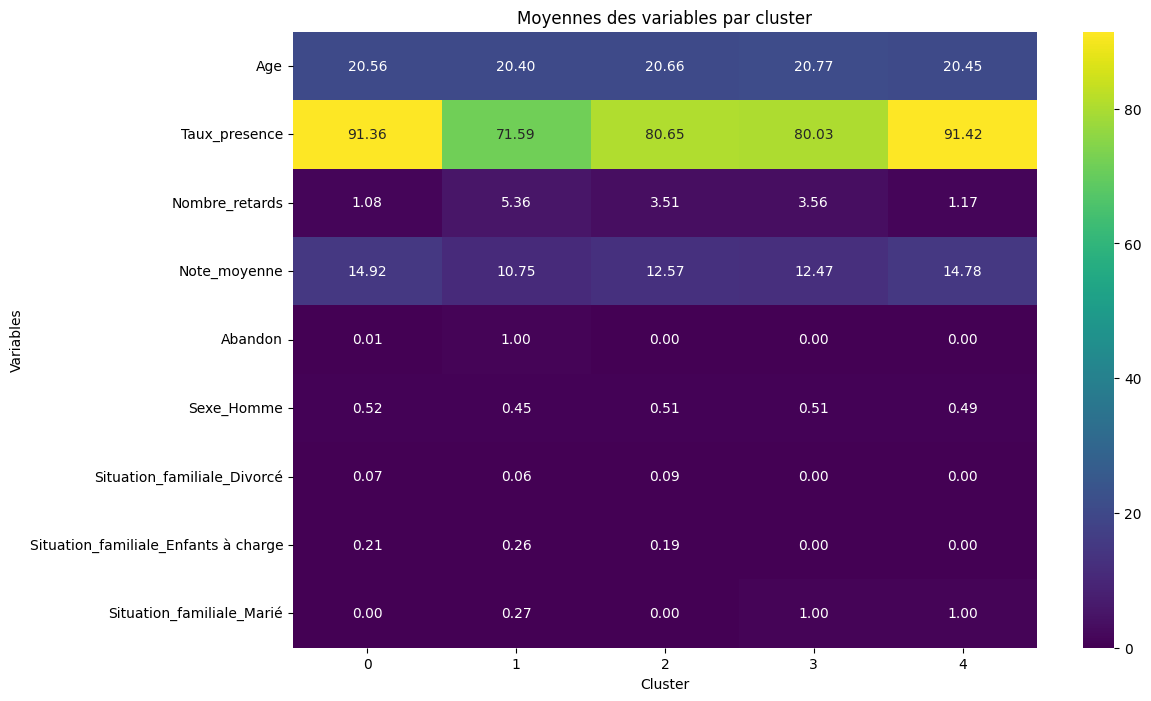

In [50]:
k_optimal = best_k
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
kmeans_final.fit(X_scaled)
labels = kmeans_final.labels_
df_with_clusters = df_encoded.copy()
df_with_clusters['Cluster'] = labels
cluster_means = df_with_clusters.groupby('Cluster').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='viridis', fmt='.2f')
plt.title('Moyennes des variables par cluster')
plt.xlabel('Cluster')
plt.ylabel('Variables')
plt.show()


Afin d’interpréter les variables en lien avec les clusters, nous n’utilisons pas la PCA, car celle-ci réduit la dimensionnalité en comprimant l’information, ce qui rend les variables d’origine difficilement interprétables. À la place, nous utilisons les variables standardisées afin de conserver la lisibilité et la signification des attributs analysés.

Après analyse, les profils suivants émergent :

Cluster 0 – Assidus (22.1%)
Présence très élevée (91%), et résultats bon (moyenne de 14.9/20).

Cluster 1 – Décrocheurs (18.6%)
Taux d’absence très élevé (72%), retards fréquents, notes les plus basses (10.8/20), une majorité de femmes (55%), et un taux d’abandon de 100%.
Ce profil nécessite une attention urgente.

Cluster 2 – Étudiants moyens (24.8%)
Profil équilibré : présence correcte (80%) et notes moyennes (12.6/20).
Représente la norme générale des étudiants.

Cluster 3 – Mariés stables (17.2%)
Tous mariés, présence correcte (80%), notes moyennes (12.5/20).
Profil stable.

Cluster 4 – Mariés performants (17.3%)
100% mariés, très assidus (91%) et très bonnes performances académiques (14.8/20).
Profil combinant stabilité personnelle et réussite scolaire.


Grâce à cette analyse, nous identifions des profils d'étudiants distincts, mettant en évidence que l’assiduité ne suffit pas à garantir la réussite académique. En revanche, la stabilité personnelle, notamment le mariage, semble corrélée à de meilleures performances. Le cluster des décrocheurs mérite une attention particulière, car il regroupe des étudiants présentant un fort absentéisme, de faibles résultats et un taux d’abandon de 100%.

-----------------------------------------------------------------------------------------------

Nous avons testé une régression logistique optimisée avec GridSearchCV afin de trouver les hyperparamètres optimaux, en utilisant une validation croisée stratifiée (Stratified K-Fold) pour répartir les données de manière proportionnelle dans les différents folds

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleurs paramètres : {'logreg__C': 0.1}
Meilleur score F1 : 0.5462
C = 0.01
  Accuracy      : 0.8615
  Log Loss      : 0.3378
  Precision     : 0.3749
  Recall        : 0.9164
  F1 Score      : 0.5305
----------------------------------------
C = 0.1
  Accuracy      : 0.8705
  Log Loss      : 0.3215
  Precision     : 0.3916
  Recall        : 0.9107
  F1 Score      : 0.5462
----------------------------------------
C = 1
  Accuracy      : 0.8695
  Log Loss      : 0.3234
  Precision     : 0.3887
  Recall        : 0.9107
  F1 Score      : 0.5437
----------------------------------------
C = 10
  Accuracy      : 0.8680
  Log Loss      : 0.3238
  Precision     : 0.3852
  Recall        : 0.9107
  F1 Score      : 0.5404
----------------------------------------
C = 100
  Accuracy      : 0.8680
  Log Loss      : 0.3239
  Precision     : 0.3852
  Recall        : 0.9107
  F1 Score      : 0.5404
----------------------------------------


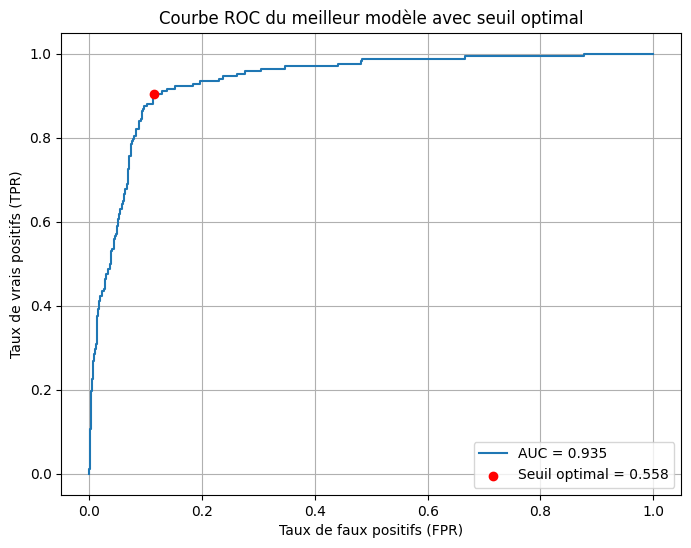

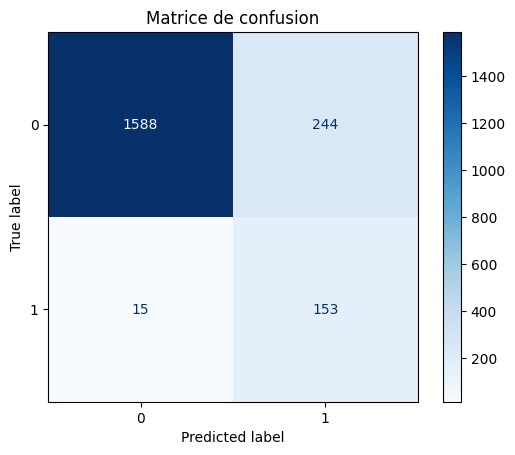

In [51]:
from sklearn.pipeline import Pipeline

X = df_encoded.drop(columns=['Abandon'])
y = df_encoded['Abandon']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'neg_log_loss': 'neg_log_loss',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, random_state=42))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=False,
    verbose=1
)

grid_search.fit(X, y)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

results = grid_search.cv_results_

for i, params in enumerate(results['params']):
    print(f"C = {params['logreg__C']}")
    print(f"  Accuracy      : {results['mean_test_accuracy'][i]:.4f}")
    print(f"  Log Loss      : {-results['mean_test_neg_log_loss'][i]:.4f}")
    print(f"  Precision     : {results['mean_test_precision'][i]:.4f}")
    print(f"  Recall        : {results['mean_test_recall'][i]:.4f}")
    print(f"  F1 Score      : {results['mean_test_f1'][i]:.4f}")
    print("-" * 40)

best_model = grid_search.best_estimator_

y_true_all = []
y_prob_all = []
y_pred_all = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # best_model est un pipeline, il fera scaler automatiquement
    best_model.fit(X_train, y_train)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    y_true_all.extend(y_test)
    y_prob_all.extend(y_prob)
    y_pred_all.extend(y_pred)

y_true_all = np.array(y_true_all)
y_prob_all = np.array(y_prob_all)
y_pred_all = np.array(y_pred_all)

fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
auc = roc_auc_score(y_true_all, y_prob_all)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.scatter(optimal_fpr, optimal_tpr, color='red', label=f'Seuil optimal = {optimal_threshold:.3f}', zorder=5)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC du meilleur modèle avec seuil optimal')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

Analyse et Conclusion du Modèle de Régression Logistique :

Résultats clés :
Accuracy (87%) : Le modèle prédit correctement la classe globale dans une large majorité des cas. Cependant, ce score peut être trompeur en présence de classes déséquilibrées.

Précision (39%) : Lorsque le modèle prédit un abandon, il se trompe souvent (nombre important de faux positifs), ce qui signifie que 61 % des prédictions positives sont incorrectes.

Rappel (91%) : Le modèle détecte la quasi-totalité des vrais abandons, avec peu de faux négatifs.

F1-score (54%) : Ce score modéré reflète un compromis moyen entre précision et rappel, indiquant qu’il y a encore une marge d’amélioration possible.

Matrice de confusion :
Vrais négatifs (VN) : 1 586

Faux positifs (FP) : 246

Faux négatifs (FN) : 15

Vrais positifs (VP) : 153

Le modèle identifie efficacement les classes positives et négatives, avec un faible nombre de faux négatifs, ce qui est crucial pour la détection des abandons. Cependant, le nombre notable de faux positifs peut entraîner des interventions inutiles.

Courbe ROC et AUC :
Grâce à GridSearchCV, nous avons pu optimiser les hyperparamètres, ce qui a permis d’atteindre une excellente capacité globale de discrimination, illustrée par un score AUC élevé de 0.935. Ce résultat montre que le modèle sait bien distinguer les classes positives des classes négatives sur l’ensemble des seuils possibles.

Conclusion générale pour la régression logistique :

Le modèle est performant pour détecter les abandons, avec un rappel très élevé qui garantit peu de cas manqués. Toutefois, la faible précision reflète un taux important de fausses alertes, ce qui peut être problématique en pratique. Malgré un excellent score AUC, le F1-score modéré indique que des améliorations sont possibles, notamment en ajustant le seuil de classification ou en enrichissant le jeu de données.

-----------------------------------------------------------------------------------------------

Nous avons testé un KNN optimisée avec GridSearchCV afin de trouver les hyperparamètres optimaux, en utilisant une validation croisée stratifiée (Stratified K-Fold) pour répartir les données de manière proportionnelle dans les différents folds

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs paramètres KNN : {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Meilleur score F1 (GridSearchCV) : 0.5229
Seuil optimal (tpr - fpr max) : 0.111
Accuracy : 0.8495
Precision : 0.3512
Recall : 0.9345
F1-score : 0.5106


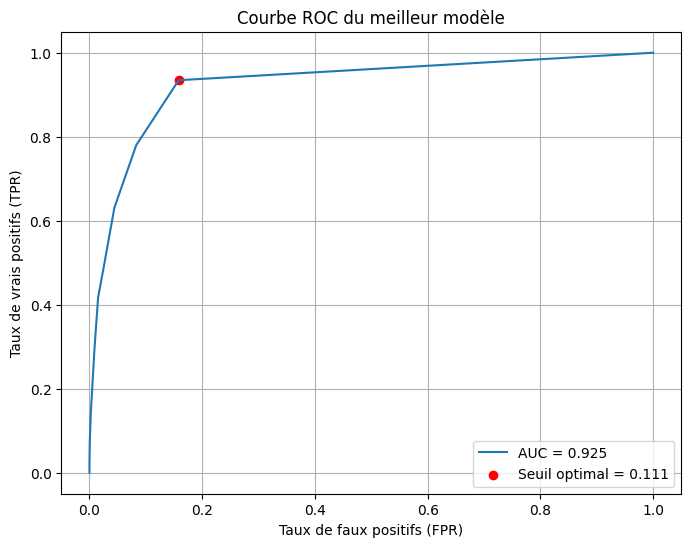

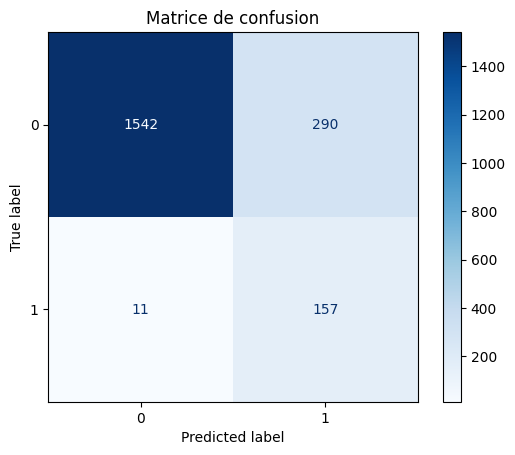

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)
print("Meilleurs paramètres KNN :", grid.best_params_)
print("Meilleur score F1 (GridSearchCV) :", round(grid.best_score_, 4))

best_knn = grid.best_estimator_

y_true_all = []
y_prob_all = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    best_knn.fit(X_train, y_train)
    y_prob = best_knn.predict_proba(X_test)[:, 1]

    y_true_all.extend(y_test)
    y_prob_all.extend(y_prob)

y_true_all = np.array(y_true_all)
y_prob_all = np.array(y_prob_all)

fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Seuil optimal (tpr - fpr max) :", round(optimal_threshold, 3))


y_pred_final = (y_prob_all >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_true_all, y_pred_final)
precision = precision_score(y_true_all, y_pred_final)
recall = recall_score(y_true_all, y_pred_final)
f1 = f1_score(y_true_all, y_pred_final)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

cm = confusion_matrix(y_true_all, y_pred_final)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Seuil optimal = {optimal_threshold:.3f}')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC du meilleur modèle')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

Analyse et Conclusion du Modèle K-Nearest Neighbors (KNN) :
Résultats clés :

Accuracy (84,95%) : Le modèle prédit correctement la classe globale dans une grande majorité des cas, ce qui reste un bon indicateur de performance globale. Cependant, ce score peut masquer un déséquilibre des classes.

Précision (35,12%) : Lorsque le modèle prédit un abandon, il est correct un peu plus d’un tiers du temps, ce qui reste une amélioration à analyser par rapport à d’autres modèles. Cela signifie que les faux positifs sont encore présents mais réduits.

Rappel (93,45%) : Le modèle détecte la très grande majorité des abandons, ce qui est un point fort important pour ne pas manquer de cas positifs.

F1-score (51,06%) : Ce score traduit un compromis modéré entre précision et rappel, indiquant que le modèle KNN gère globalement bien la détection des abandons, même si la précision reste faible.

Matrice de confusion :

Vrais négatifs (VN) : 1 542

Faux positifs (FP) : 290

Faux négatifs (FN) : 11

Vrais positifs (VP) : 157

Le modèle KNN réduit le nombre de faux négatifs, ce qui est crucial pour la détection des abandons. En revanche, le nombre de faux positifs est relativement élevé, ce qui peut générer plus de fausses alertes.

Courbe ROC et AUC :
Grâce à la recherche par GridSearchCV et au choix du seuil optimal (0.111), le modèle atteint une très bonne capacité globale de discrimination, avec un score AUC de 0.925. Cela montre que le modèle sait globalement bien séparer les classes positives et négatives.

Conclusion générale pour le modèle KNN :
Le modèle KNN offre un bon compromis avec un rappel très élevé, ce qui limite les abandons non détectés. La précision reste faible, indiquant des fausses alertes qui peuvent être coûteuses selon le contexte métier. Le F1-score modéré reflète ce compromis entre détection et erreurs. Avec un AUC très bon, ce modèle est globalement robuste mais nécessite une réflexion sur l’équilibre entre faux positifs et faux négatifs selon les priorités métier.

-----------------------------------------------------------------------------------------------

Nous avons testé un random forest optimisée avec GridSearchCV afin de trouver les hyperparamètres optimaux, en utilisant une validation croisée stratifiée (Stratified K-Fold) pour répartir les données de manière proportionnelle dans les différents folds

=== Meilleur Modèle Random Forest ===
F1 Score moyen (cross-val) : 0.7000
Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Seuil optimal basé sur la courbe ROC : 0.1273
TPR : 0.9464 | FPR : 0.1223


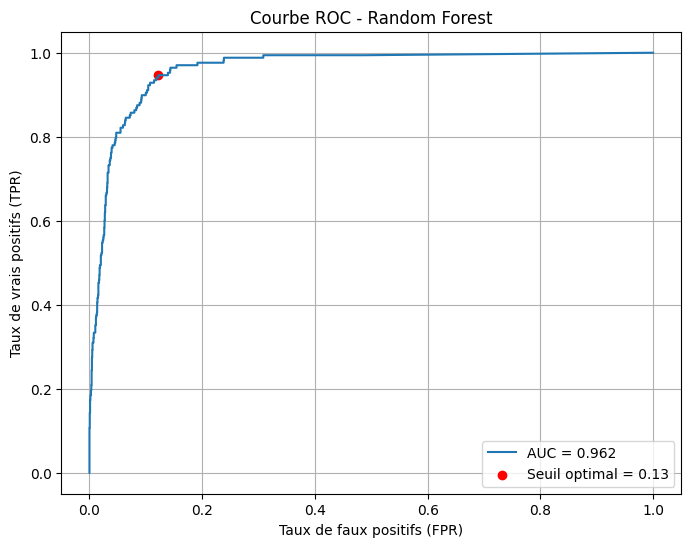

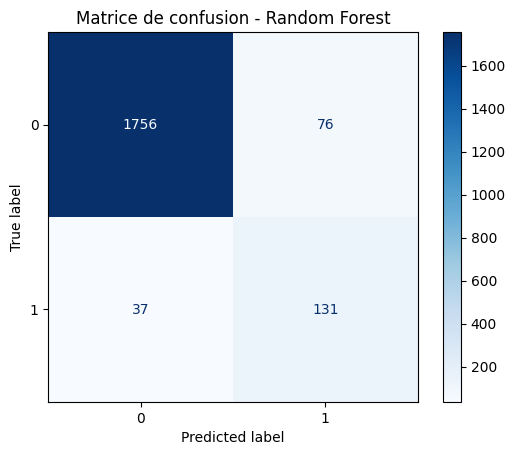

In [53]:
scoring = {
    'accuracy': 'accuracy',
    'neg_log_loss': 'neg_log_loss',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

model = RandomForestClassifier(class_weight='balanced', random_state=42)



param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=skf,
    return_train_score=False,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X, y)

print("=== Meilleur Modèle Random Forest ===")
print(f"F1 Score moyen (cross-val) : {grid_search.best_score_:.4f}")
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")
print("=====================================")

best_model = grid_search.best_estimator_

y_true_all, y_prob_all, y_pred_all = [], [], []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)

    y_true_all.extend(y_test)
    y_prob_all.extend(y_prob)
    y_pred_all.extend(y_pred)

y_true_all = np.array(y_true_all)
y_prob_all = np.array(y_prob_all)
y_pred_all = np.array(y_pred_all)


fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
auc = roc_auc_score(y_true_all, y_prob_all)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"Seuil optimal basé sur la courbe ROC : {optimal_threshold:.4f}")
print(f"TPR : {optimal_tpr:.4f} | FPR : {optimal_fpr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.scatter(optimal_fpr, optimal_tpr, color='red', label=f'Seuil optimal = {optimal_threshold:.2f}')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Random Forest")
plt.show()


Accuracy (~94%) : Le modèle prédit correctement la majorité des cas, ce qui est un excellent indicateur global, même si l'accuracy peut être trompeuse en cas de déséquilibre de classes.

Précision : 63.3 %
Le modèle montre une capacité raisonnable à ne pas produire trop de faux positifs. Lorsqu’il prédit un abandon, cette prédiction est correcte dans la majorité des cas, ce qui permet de limiter les actions inutiles.

Rappel (77.9%) : Il détecte une bonne proportion des cas réels d’abandon, même si ce rappel est légèrement inférieur à celui du modèle de régression.

F1-score moyen (validation croisée) : 0.700
Ce score indique un bon équilibre entre la précision et le rappel du modèle, ce qui est particulièrement important dans un contexte où l’on cherche à détecter les abandons tout en limitant les fausses alertes.

Vrais négatifs (TN) : 1 756

Faux positifs (FP) : 76

Faux négatifs (FN) : 37

Vrais positifs (TP) : 131

Le modèle Random Forest :

Réduit fortement le nombre de faux positifs (76 vs 246 avec la régression).

A légèrement plus de faux négatifs (37 vs 15), mais le trade-off est largement bénéfique car il améliore la précision.

AUC : 0.962
La courbe ROC montre une excellente capacité de discrimination du modèle. Le score AUC proche de 1 reflète la capacité du modèle à classer correctement les exemples positifs et négatifs, quelle que soit la valeur seuil choisie.

Cela indique une très bonne capacité de discrimination, avec une séparation efficace entre les classes positives et négatives, quelle que soit la valeur seuil.

Le modèle Random Forest offre des performances solides, avec un bon compromis entre détection des abandons et limitation des erreurs de classification. Grâce à un réglage précis de ses hyperparamètres, il fournit une base fiable pour prendre des décisions prédictives dans un contexte métier sensible à la détection des comportements à risque. 

-----------------------------------------------------------------------------------------------

conclusion :

Tableau de comparaison des modèles :

| **Métrique**           | **Régression Logistique** | **Random Forest** | **K-Nearest Neighbors (KNN)** |
| ---------------------- | ------------------------- | ----------------- | ----------------------------- |
| **Accuracy**           | 87.0 %                    | **94.0 %**        | 85 %                          |
| **Précision**          | 39.0 %                    | **63.3 %**        | 35.1 %                        |
| **Rappel**             | **91.0 %**                | 77.9 %            | 93.5 %                        |
| **F1-Score**           | 54.0 %                    | **70.0 %**        | 51.8 %                        |
| **AUC (ROC)**          | 0.935                     | **0.962**         | 0.925                         |
| **Faux positifs (FP)** | 244                       | **76**            | 290                           |
| **Faux négatifs (FN)** | **15**                    | 37                | 11                            |


Parmi les trois, Random Forest apparaît comme le meilleur compromis global. Il offre un équilibre solide entre performance prédictive, gestion du déséquilibre de classes, et stabilité, tout en minimisant les erreurs critiques (faux positifs ou faux négatifs).

Toutefois, le choix final du modèle dépendra des priorités métier :

Si l’objectif est d’identifier un maximum d’élèves à risque, la régression logistique peut être privilégiée.

Si l’objectif est d’éviter les interventions inutiles, Random Forest ou KNN sont mieux adaptés.



-----------------------------------------------------------------------------------------------

Nous recommandons, pour les travaux futurs, d’enrichir le dataset en augmentant le volume de données disponibles. Un jeu de données plus vaste permettrait d’améliorer la robustesse des modèles, de mieux capter la variabilité des profils étudiants et d’obtenir des prédictions plus fiables.

Par ailleurs, nous suggérons d’explorer des modèles basés sur les arbres de décision, tels que XGBoost. Bien qu’ils nécessitent davantage de ressources en calcul, ces modèles sont généralement plus performants, notamment pour gérer les interactions complexes entre variables et les déséquilibres de classes.